Clipping an image, code

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


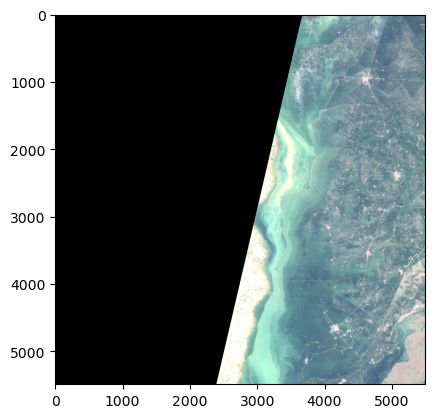

In [11]:
# import our necessary packages
import rasterio # rasterio helps us read the raster image file
from matplotlib import pyplot as plt # pyplot helps us plot/visualize our image data
import numpy as np # numpy helps us scale our underlying band values

# specify file to import
image_file = "Sep_05_RUR_merged_2x.tif"

# define it as a rasterio object so we can use rasterio functions
my_raster_image = rasterio.open(image_file)

# scale values for display purposes
def scale(band): 
    return band / 150.0

# import our multiband layers - blue, green red
blue = scale(my_raster_image.read(4))
green = scale(my_raster_image.read(3))
red = scale(my_raster_image.read(2))
nir = scale(my_raster_image.read(1))

# stack them into a single image for a true color composite
my_image = np.dstack((red, green, blue,))

# show the image using pylot
plt.imshow(my_image)

In [2]:
# get x and y bounds
xmin, ymin, xmax, ymax = my_raster_image.bounds

# Let's get the x and y range first 
x_range = xmax - xmin
y_range = ymax - ymin
print(round(x_range), round(y_range))

print("Initial values are {}, {}, {} and {}".format(
    round(xmin), 
    round(ymin), 
    round(xmax), 
    round(ymax))
)

# Respecify the maximum values to be smaller to get an AoI inside this existing image
xmin = 380000
ymin = 3073890
xmax = 406000
ymax = 3088260


# Check final values
print("Final values are {}, {}, {} and {}".format(
    round(xmin), 
    round(ymin), 
    round(xmax), 
    round(ymax))
)

109800 109800
Initial values are 300000, 2990220, 409800 and 3100020
Final values are 380000, 3073890, 406000 and 3088260


In [3]:
# define the geometry type, which is a polygon  
my_geojson = [{
	"type": "Polygon", 
	"coordinates": [ 
	  [
		[xmin, ymin],
		[xmax, ymin],
		[xmax, ymax],
		[xmin, ymax],
		[xmin, ymin]
	  ],
	]
  }]
my_geojson

[{'type': 'Polygon',
  'coordinates': [[[380000, 3073890],
    [406000, 3073890],
    [406000, 3088260],
    [380000, 3088260],
    [380000, 3073890]]]}]

In [4]:
# Masking is a technique used to clarify dense or detailed map content by having 
# the features of one layer hide, or mask, features of another layer where they overlap
from rasterio.mask import mask

In [5]:
# apply the rasterio mask 
# specify the function needs to crop (via crop=True)
with rasterio.open(image_file) as img:
    clipped_s1, transform = mask(img, my_geojson, crop=True)
    
# view your clipped multiband numpy array
print(clipped_s1)

[[[1620. 1759. 1598. ... 2891. 2882. 3038.]
  [1627. 1701. 1575. ... 2773. 2886. 3111.]
  [1610. 1658. 1586. ... 3124. 3153. 3064.]
  ...
  [1447. 1448. 1447. ... 2364. 2547. 2669.]
  [1435. 1446. 1454. ... 2628. 2677. 2668.]
  [1443. 1449. 1449. ... 2251. 1939. 2036.]]

 [[  66.   75.   68. ...   57.   60.   74.]
  [  68.   73.   66. ...   61.   61.   59.]
  [  70.   73.   67. ...   61.   56.   56.]
  ...
  [  58.   58.   59. ...   75.   75.   90.]
  [  59.   59.   59. ...  116.  109.  118.]
  [  58.   59.   59. ...   90.   76.   72.]]

 [[  84.   89.   85. ...   79.   79.   90.]
  [  86.   88.   85. ...   79.   80.   79.]
  [  89.   89.   85. ...   79.   77.   77.]
  ...
  [  89.   89.   89. ...   86.   84.   96.]
  [  89.   89.   89. ...  115.  110.  113.]
  [  89.   89.   89. ...  102.   96.   93.]]

 [[  94.   97.   94. ...   85.   86.   93.]
  [  94.   97.   94. ...   86.   85.   86.]
  [  96.   96.   94. ...   87.   83.   85.]
  ...
  [  90.   89.   90. ...   90.   90.   98.]
  

In [6]:
# copy the metadata from the original ratserio object
meta = my_raster_image.meta.copy()

# update metadata, and provide the new clipped boundaries
meta.update(
    {
    
        "transform": transform,
        "height":clipped_s1.shape[1],
        "width":clipped_s1.shape[2]
    }
)
print(meta) # show metadata

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 1300, 'height': 719, 'count': 4, 'crs': CRS.from_epsg(32642), 'transform': Affine(20.0, 0.0, 380000.0,
       0.0, -20.0, 3088260.0)}


In [7]:
# Now we write new image to a GeoTIFF, 'w' is write
with rasterio.open('clipped_Sep_05_RUR_qambar_4x.tif', 'w', **meta) as my_writer_object:
    my_writer_object.write(clipped_s1)
    
print('Writing complete')

Writing complete
